# Image emotion detection

Using the [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset. First download and extract the dataset and place it in the working directory as `fer-2013-dataset`.

The dataset contains 48×48 grayscale pictures cropped to faces. Each picture has a label describing the represented emotion. The dataset is already split into train/test subsets which we will soon explore. The goal of this project is to create a model which will be able to predict what emotion is present on a person's face. To do so tensorflow with keras will be used and the model will be based off CNN. 

In [3]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import keras


# for reproducable results
seed = 123

train_dir = Path("fer-2013-dataset/train")
test_dir = Path("fer-2013-dataset/test")
checkpoint_file = Path('model.h5')
final_model_file = Path('final_model.h5')
log_file = Path('training.log.csv')

model_to_load = final_model_file

image_size = (48, 48)
n_classes = sum(1 for _ in train_dir.glob("*"))


## Dataset analysis

Below some of the samples were plotted to perform some general dataset analysis.

Training samples:


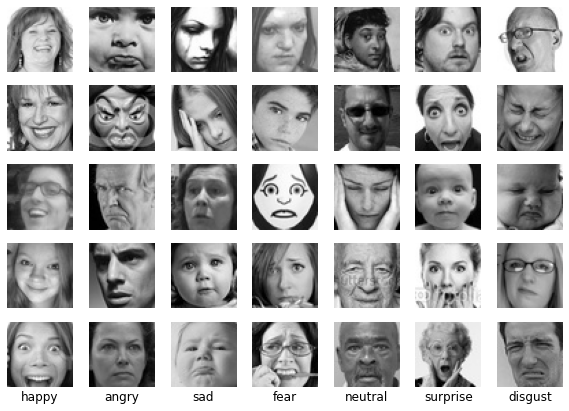

Testing samples:


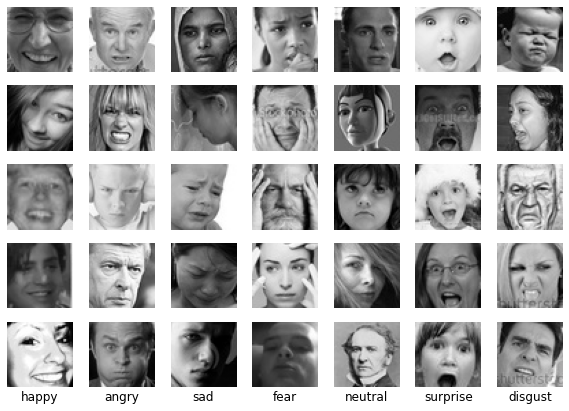

In [4]:
from tensorflow.keras.utils import load_img


def show_samples(dir: Path):
    plt.figure(figsize=(10, 7))
    sample = 5
    for (i, emotion) in enumerate(dir.glob("*")):
        imgs = emotion.glob("*")
        for n in range(sample):
            img = load_img(emotion.joinpath(next(imgs).name))
            plt.subplot(sample, n_classes, i+1 + n_classes*n)
            plt.imshow(img)
            plt.axis('off')
        plt.title(emotion.name, y=-0.3)

    plt.show()


print('Training samples:')
show_samples(train_dir)
print('Testing samples:')
show_samples(test_dir)


We can quickly notice a few things. Firstly, the faces seem nicely centered though even if they weren't CNNs inherently are translate-invariant so it would not be a problem. Secondly, the training and testing set does not seem to differ substantially.

On the other hand, many issues can be identified:

1. Many of the pictures are stock pictures where the emotion is grossly exaggerated. This may cause the model to fail to learn the subtleties of how an emotion is expressed.
2. Different scales/rotations. Kernels in a CNN are not scale/rotation-invariant and will fail to generalize for different sizes/rotations of studied objects (lips, eyebrows, etc). Layers such as maxpooling are said to be helping here [[Deep Learning. Ian Goodfellow and Yoshua Bengio and Aaron Courville](https://www.deeplearningbook.org/)]
3. Different lightning conditions.
4. Mixture of real pictures with computer drawn. 
5. All previous arguments are technical limitations which can be overcome. However, one last important problem which can be noticed is that some of these emotion labels are very debatable. Me (as a fellow human) would fail to classify some of those to the associated label.

With all of that in mind, and our expectations being managed we proceed to prepare our model.

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


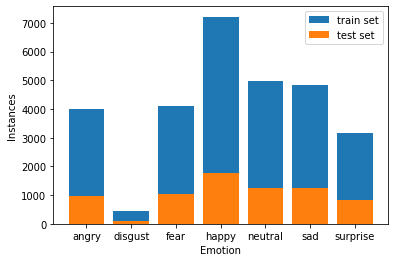

In [2]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

batch_size = 32

train_datagen = ImageDataGenerator(
    # normalize pixels to [0; 1]
    rescale=1/255,

    # will act as a regularizer
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True)
train = train_datagen.flow_from_directory(train_dir,
                                          batch_size=batch_size,
                                          target_size=image_size,
                                          shuffle=True,
                                          color_mode='grayscale',
                                          class_mode='categorical',
                                          seed=seed)

test_datagen = ImageDataGenerator(rescale=1/255)
test = test_datagen.flow_from_directory(test_dir,
                                        batch_size=batch_size,
                                        target_size=image_size,
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                        seed=seed)


def plot_dist(t_set: DirectoryIterator, legend: str) -> dict[str, int]:
    counts = {
        cl: np.count_nonzero(t_set.classes == i)
        for (cl, i) in t_set.class_indices.items()
    }
    plt.bar(counts.keys(), counts.values(), label=legend)
    plt.xlabel('Emotion')
    plt.ylabel('Instances')
    plt.legend()

    return counts


dist1 = plot_dist(train, 'train set')
dist2 = plot_dist(test, 'test set')


The data is loaded straight from the directories using the keras helper function `flow_from_directory`. All images are normalized by rescaling pixels to the $[0; 1]$ range and labels are encoded using one-hot encoding. We seed everything with our previously defined `seed` and prepare examples in batches. We also introduce a little bit of noise in the training examples: rotation, scaling, and horizontal flips. It will act as a simple regularizer.

## Constructing the model


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 128)      

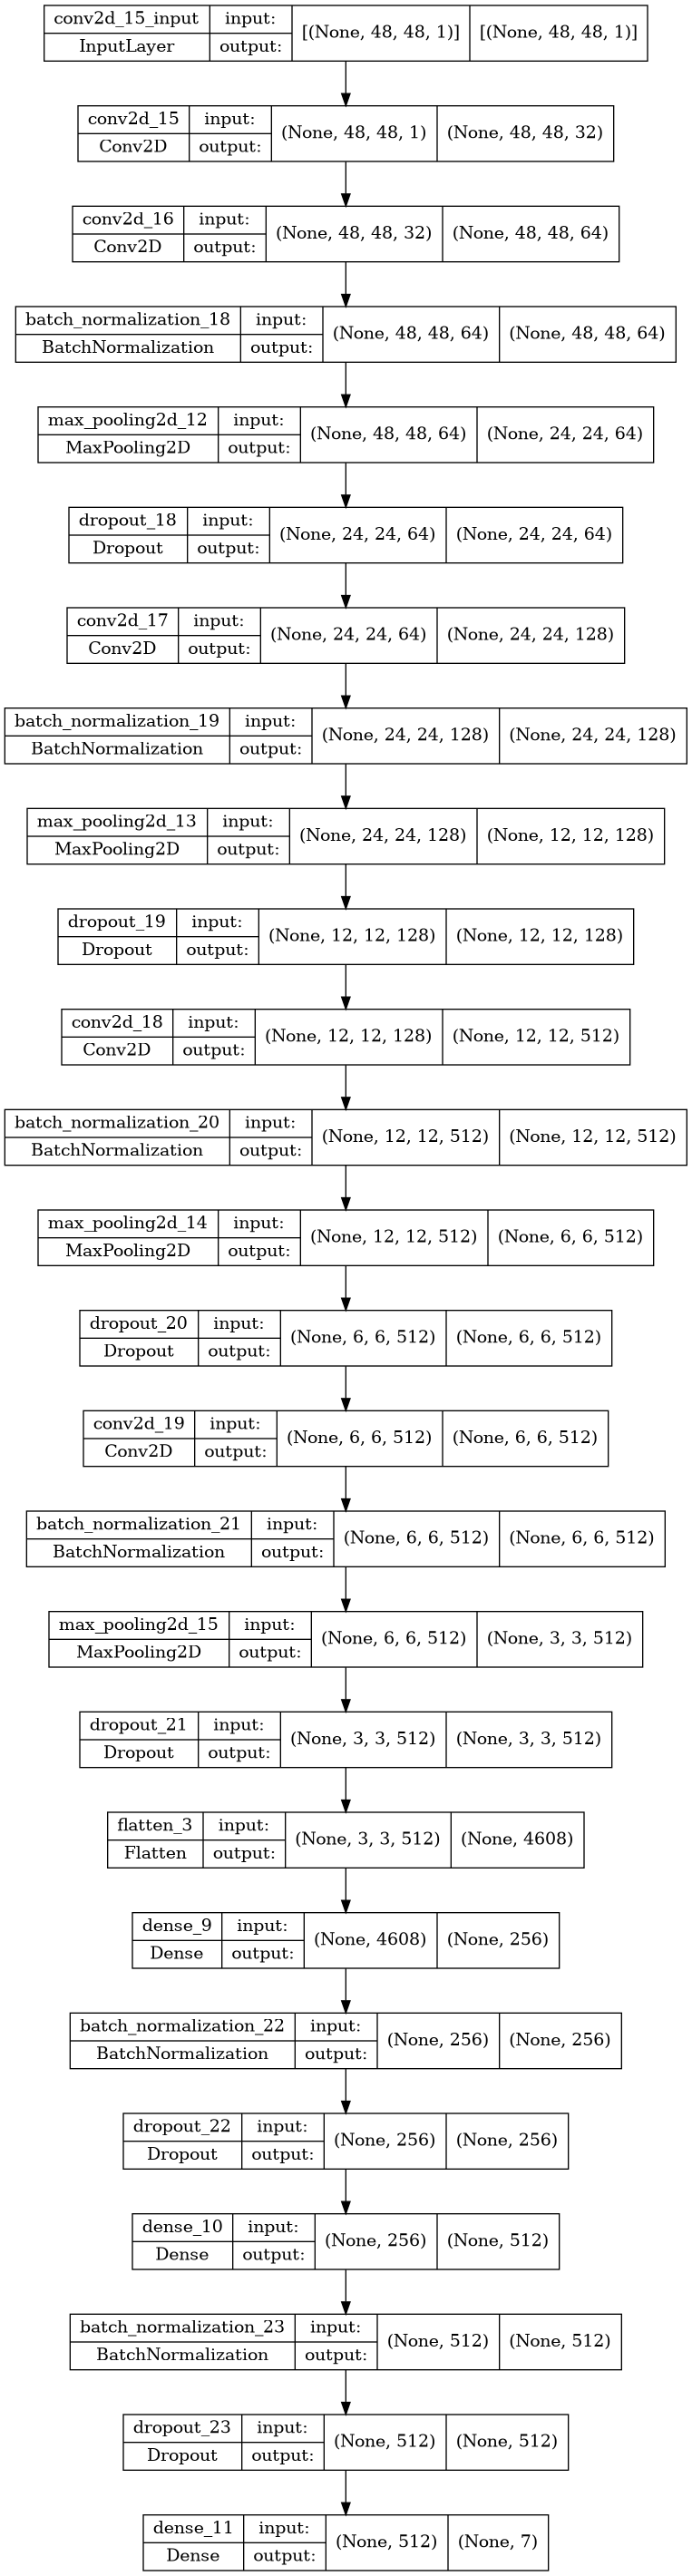

In [118]:
from tensorflow.keras.utils import plot_model


def get_model():
    if model_to_load is not None:
        return keras.models.load_model(model_to_load)

    from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input
    from keras import regularizers
    from tensorflow.keras.optimizers import Adam

    input = Input(shape=(*image_size, 1))

    conv11 = Conv2D(32, kernel_size=(3, 3), padding='same',
                    activation='relu')(input)
    conv12 = Conv2D(64, kernel_size=(3, 3), padding='same',
                    activation='relu')(conv11)
    normalize1 = BatchNormalization()(conv12)
    pool1 = MaxPool2D(pool_size=(2, 2))(normalize1)
    dropout1 = Dropout(0.25)(pool1)

    conv21 = Conv2D(128, kernel_size=(5, 5), padding='same',
                    activation='relu')(dropout1)
    normalize2 = BatchNormalization()(conv21)
    pool2 = MaxPool2D(pool_size=(2, 2))(normalize2)
    dropout2 = Dropout(0.25)(pool2)

    conv31 = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu',
                    kernel_regularizer=regularizers.l2(0.01))(dropout2)
    normalize3 = BatchNormalization()(conv31)
    pool3 = MaxPool2D(pool_size=(2, 2))(normalize3)
    dropout3 = Dropout(0.25)(pool3)

    conv41 = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu',
                    kernel_regularizer=regularizers.l2(0.01))(dropout3)
    normalize4 = BatchNormalization()(conv41)
    pool4 = MaxPool2D(pool_size=(2, 2))(normalize4)
    dropout4 = Dropout(0.25)(pool4)

    flat = Flatten()(dropout4)
    dense1 = Dense(256, activation='relu')(flat)
    normalize5 = BatchNormalization()(dense1)
    dropout5 = Dropout(0.25)(normalize5)

    dense2 = Dense(512, activation='relu')(dropout5)
    normalize6 = BatchNormalization()(dense2)
    dropout6 = Dropout(0.25)(normalize6)

    output = Dense(n_classes, activation='softmax')(dropout6)

    model = keras.models.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=3e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = get_model()
model.summary()
plot_model(model, show_shapes=True)


Now that the model is built, some callbacks will be added to monitor the training process. In this case only three will be added. One will save the best performing model and the other will reduce the learning rate if the training progress has stagnated (both with respect to the validation loss). Finally a simple logger will be added to be able to retroactively track the training process.

In [114]:
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_file,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min')


reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    verbose=1,
    patience=10)

logger = keras.callbacks.CSVLogger(
    log_file, append=(model_to_load is not None))


callbacks = [checkpoint, reduce_lr, logger]


Finally, we train our model using the test set as training validation and with the previously defined callbacks.

In [15]:
_ = model.fit(x=train, validation_data=test, epochs=200, callbacks=callbacks)

Save the final model.

In [17]:
model.save(final_model_file)

## Result analysis

Once done, we proceed to analyzing our results: we check basic measures such as accuracy and loss on both sets. As we can see, both sets have very comparable results, which tells us no overfitting occurred during training.

In [221]:
_ = model.evaluate(train)
_ = model.evaluate(test)

225/225 [==============================] - 11s 51ms/step - loss: 1.0202 - accuracy: 0.6698


Next, the training history:

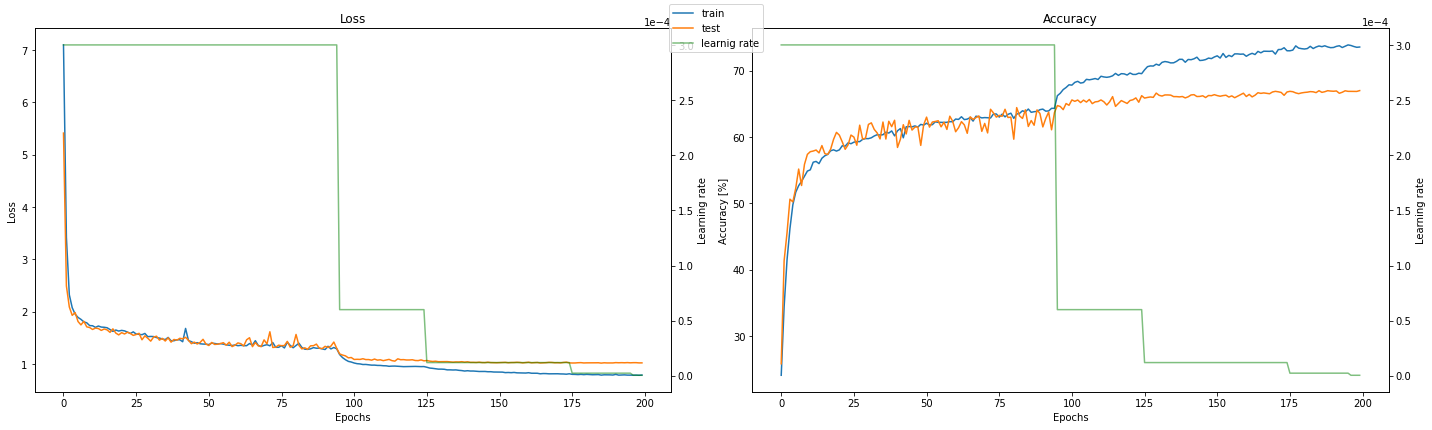

In [220]:
import csv

with open(log_file) as f:
    reader = csv.DictReader(f)
    data = [*reader]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))


line1 = ax1.plot([float(x['loss']) for x in data], label="train")
line2 = ax1.plot([float(x['val_loss']) for x in data], label="test")
ax1_2 = ax1.twinx()
line3 = ax1_2.plot([float(x['lr']) for x in data], 'g-',
                   alpha=0.5, label="learnig rate")
ax1_2.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1_2.set_ylabel('Learning rate')

ax2.plot(np.array([float(x['accuracy']) for x in data]) * 100)
ax2.plot(np.array([float(x['val_accuracy']) for x in data]) * 100)
ax2_2 = ax2.twinx()
ax2_2.plot([float(x['lr']) for x in data], 'g-', alpha=0.5,)
ax2_2.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax2.set_title('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy [%]')
ax2_2.set_ylabel('Learning rate')


lines = line1+line2+line3
labels = [l.get_label() for l in lines]
fig.legend(lines, labels, loc='upper center')
fig.tight_layout()

plt.show()


We can immediately notice a few interesting things: the model learns to classify images effectively within just a few initial epochs. Afterwards the improvement slows down dramatically. After the first learning rate decrease we can notice a sudden improvement in both sets. While initially the loss does not diverge in a significant matter between the sets, at around epoch 125 (when the second learning rate drop is applied) we can notice that the test set (here used as a validation set) no longer reports improvements and the model is clearly starting to overfit the dataset. 

Notice, that a result of 67% for emotion recognition is not a bar result: after all, emotions are ambiguous and often hard to describe with just a single term. Perhaps multi-classification would prove to be better for such a task. Additionally, emotions are far from being linearly different. That is, sadness and neutrality do not differ greatly when expressed facially. On the other hand, happiness and angriness are much more distinct. Classes have different distances between each other.

The learning rate reductions clearly show the model reaching a more stable performance. Ideally, training should be stopped either right after the first LR drop, or right before the second one.

[[7.15894869e-01 7.79816514e-02 7.44447156e-02 5.26680527e-03
  1.69184290e-02 5.85921325e-02 1.16682435e-02]
 [5.50688360e-03 8.41743119e-01 2.44081035e-04 0.00000000e+00
  0.00000000e+00 8.28157350e-04 1.26143173e-03]
 [5.13141427e-02 1.14678899e-02 5.75787161e-01 4.15800416e-03
  1.10775428e-02 4.24430642e-02 3.68968780e-02]
 [1.87734668e-02 2.29357798e-03 1.92824018e-02 9.43728344e-01
  4.61228600e-02 1.09730849e-02 3.43740145e-02]
 [1.11889862e-01 1.37614679e-02 7.71296070e-02 3.14622315e-02
  8.43504532e-01 1.54865424e-01 1.48218228e-02]
 [8.38548185e-02 3.44036697e-02 1.81352209e-01 5.54400554e-03
  7.69385700e-02 7.26708075e-01 7.56859035e-03]
 [1.27659574e-02 1.83486239e-02 7.17598243e-02 9.84060984e-03
  5.43806647e-03 5.59006211e-03 8.93409019e-01]]
[[0.58350731 0.20720721 0.1171875  0.01465614 0.03163017 0.08179631
  0.0276775 ]
 [0.01461378 0.61261261 0.00585938 0.0011274  0.         0.00160385
  0.00120337]
 [0.05323591 0.04504505 0.34960938 0.00958286 0.0243309  0.056134

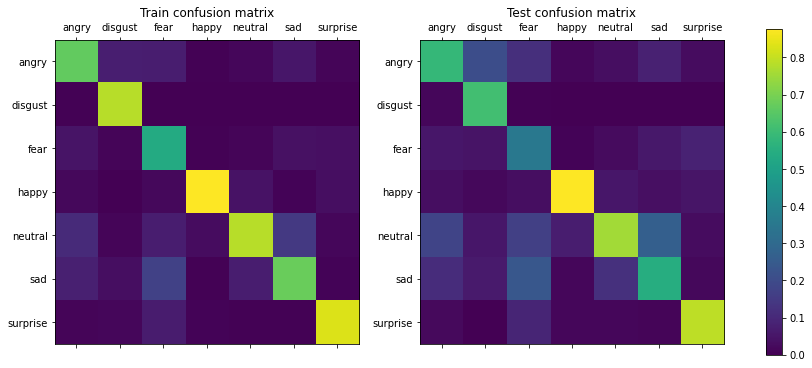

In [219]:
def confusion_matrix(data: DirectoryIterator) -> np.array:
    m = np.zeros((n_classes, n_classes), dtype='int')

    data.shuffle = False
    data.index_array = None
    data.reset()
    y_hat = model.predict(data)

    for (c_hat, c) in zip(y_hat.argmax(axis=1), data.classes):
        m[c_hat, c] += 1

    sums = m.sum(axis=0)
    normalized = (m.T / sums[:, None]).T

    return normalized


def plot_confusion_matrix(matrix: np.array, fig: plt.Figure, axis: plt.Axes, title: str, show_color_bar=False):
    cax = axis.matshow(matrix)
    axis.set_xticks(list(train.class_indices.values()))
    axis.set_xticklabels(train.class_indices.keys())
    axis.set_yticks(list(train.class_indices.values()))
    axis.set_yticklabels(train.class_indices.keys())
    axis.set_title(title)

    return cax


train_confusion_matrix = confusion_matrix(train)
test_confusion_matrix = confusion_matrix(test)
print(train_confusion_matrix)
print(test_confusion_matrix)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_confusion_matrix(train_confusion_matrix, fig,
                      ax1, 'Train confusion matrix')
cax = plot_confusion_matrix(
    test_confusion_matrix, fig, ax2, 'Test confusion matrix', show_color_bar=True)

fig.colorbar(cax, ax=[ax1, ax2])


Lastly, the confusion matrix is shown. X-axis depicts the label and the y-axis plots the distribution of the model's predictions. As expected the brightest parts are on the diagonal (true positives). Train's and test's confusion matrices exhibit a similar pattern, which enforces the belief that the model managed to not overfit the train set. The brightest class seems to be _'happy'_, which was predicted correctly 87% of the time in the test set and 94% in the train set. The small amount of examples of disgust is visible here: when y=disgust, x is only bright for disgust. Occasional brighter parts outside of the diagonal can be observed, these can be probably attributed to ambiguous pictures; the biggest confusion seems to be classifying fear as sadness, and classifying sadness as neutrality.